In [1]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 3.4 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/alexsivkovu/risks2.git

Cloning into 'risks2'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 33 (delta 9), reused 23 (delta 7), pack-reused 0
Receiving objects: 100% (33/33), 1.11 MiB | 9.04 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [3]:
%cd risks2

/content/risks2


In [4]:
import numpy as np
import pandas as pd
import datetime
import calc_factors
from calc_factors import dataset, financial_columns, calc_and_simulate_risk_factors
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.decomposition import FastICA
from statsmodels.tsa.stattools import adfuller
import arch
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

# Пункт 5

In [5]:
# Загрузка данных
dataset = pd.read_excel('dataset_coupons.xlsx')

financial_columns = ['close_B_1', 'close_B_2', 'close_B_3', 'close_B_4', 'close_B_5',
                     'close_AFKS', 'close_AGRO', 'close_BRENT', 'close_EUR_RUB__TOD',
                     'close_GAZP', 'close_IMOEX', 'close_LKOH', 'close_NLMK', 'close_NVTK',
                     'close_PLZL', 'close_ROSN', 'close_RTKM', 'close_RTSI', 'close_SBER',
                     'close_USD000000TOD', '%_0,25y', '%_0,5y', '%_0,75y', '%_1y', '%_2y',
                     '%_3y', '%_5y', '%_7y', '%_10y', '%_15y', '%_20y', '%_30y']

def get_risk_factors(dt_end=datetime.date(2023, 12, 3), dataset=dataset, financial_columns=financial_columns):
    dt_end_datetime = pd.to_datetime(dt_end)
    dataset = dataset[dataset['dt'] < dt_end_datetime].reset_index(drop=True)
    df_financial = dataset[financial_columns]

    ica = FastICA(n_components=10, algorithm='parallel', whiten='unit-variance', fun='logcosh', max_iter=300)
    ica_components = ica.fit_transform(df_financial)
    df_ica = pd.DataFrame(data=ica_components)
    df_ica.columns = [f'risk_factor_{i}' for i in range(len(df_ica.columns))]
    df_ica['dt'] = dataset['dt']
    df_ica = df_ica[['dt'] + [f'risk_factor_{i}' for i in range(len(df_ica.columns) - 1)]]
    dataset = dataset.merge(df_ica, how='left', on='dt')
    return dataset

def garch_simulation(df, risk_factor_col, steps_forward, num_samples):
    model = arch.arch_model(df[risk_factor_col], mean='AR', vol='Garch', p=10, o=0, q=10)
    res = model.fit(disp='off')
    sim_data = res.forecast(horizon=steps_forward, method='simulation')
    means = sim_data.mean.iloc[0].values
    variances = sim_data.variance.iloc[0].values
    simulated_data = np.zeros((num_samples, steps_forward))
    for i in range(steps_forward):
        std_dev = np.sqrt(variances[i])
        simulated_data[:, i] = np.random.normal(means[i], std_dev, num_samples)
    return simulated_data

def calc_and_simulate_risk_factors(dt_end=datetime.date(2023, 12, 3), steps_forward=1, num_samples=1000, dataset=dataset, financial_columns=financial_columns):
    df_risks = get_risk_factors(dt_end=dt_end, dataset=dataset, financial_columns=financial_columns)
    df = df_risks[[f'risk_factor_{i}' for i in range(10)]].copy()
    df.index = df_risks['dt']
    dict_of_risk_simulations = {}
    for risk_factor_col in df.columns:
        dict_of_risk_simulations[risk_factor_col] = garch_simulation(df, risk_factor_col, steps_forward=steps_forward, num_samples=num_samples)
    return df_risks, dict_of_risk_simulations

df_risks, dict_of_risk_simulations = calc_and_simulate_risk_factors(dt_end=datetime.date(2023, 12, 20), steps_forward=1, num_samples=1000)

In [6]:
def calculate_portfolio_values(df_risks, risk_simulations, initial_prices, portfolio_weights):
    num_samples = risk_simulations[next(iter(risk_simulations))].shape[0]
    portfolio_values = np.zeros(num_samples)

    for i in range(num_samples):
        sample_value = 0
        for col in initial_prices.keys():
            new_price = initial_prices[col]
            for j in range(10):
                risk_factor_col = f'risk_factor_{j}'
                new_price *= np.exp(risk_simulations[risk_factor_col][i, -1])
            sample_value += portfolio_weights[col] * new_price
        portfolio_values[i] = sample_value

    return portfolio_values

def calculate_var_es(portfolio_values, var_confidence=0.99, es_confidence=0.975):
    var_value = np.percentile(portfolio_values, (1 - var_confidence) * 100)
    es_value = portfolio_values[portfolio_values <= var_value].mean()
    return var_value, es_value

In [7]:
# Определение начальных условий
dt_end = datetime.date(2023, 12, 2)
steps_forward_1 = 1
steps_forward_10 = 10
num_samples = 1000
initial_prices = dataset[dataset['dt'] == pd.to_datetime(dt_end) - pd.Timedelta(days=1)].iloc[0][financial_columns].to_dict()

In [8]:
# Пример портфельных весов
portfolio_weights = {col: 1/len(financial_columns) for col in financial_columns}  # Равные веса

In [9]:
# Симуляции и расчет для горизонта 1 день
df_risks, risk_simulations = calc_and_simulate_risk_factors(dt_end=dt_end, steps_forward=steps_forward_1, num_samples=num_samples, dataset=dataset, financial_columns=financial_columns)
portfolio_values_1 = calculate_portfolio_values(df_risks, risk_simulations, initial_prices, portfolio_weights)
var_1, es_1 = calculate_var_es(portfolio_values_1)

print(f"1-дневный VaR (99%): {var_1}")
print(f"1-дневный ES (97.5%): {es_1}")

1-дневный VaR (99%): 0.05079833854276332
1-дневный ES (97.5%): 0.016141369108433824


In [10]:
# Симуляции и расчет для горизонта 10 дней
df_risks, risk_simulations = calc_and_simulate_risk_factors(dt_end=dt_end, steps_forward=steps_forward_10, num_samples=num_samples, dataset=dataset, financial_columns=financial_columns)
portfolio_values_10 = calculate_portfolio_values(df_risks, risk_simulations, initial_prices, portfolio_weights)
var_10, es_10 = calculate_var_es(portfolio_values_10)

print(f"10-дневный VaR (99%): {var_10}")
print(f"10-дневный ES (97.5%): {es_10}")

10-дневный VaR (99%): 0.05237243782967195
10-дневный ES (97.5%): 0.020784636797057977


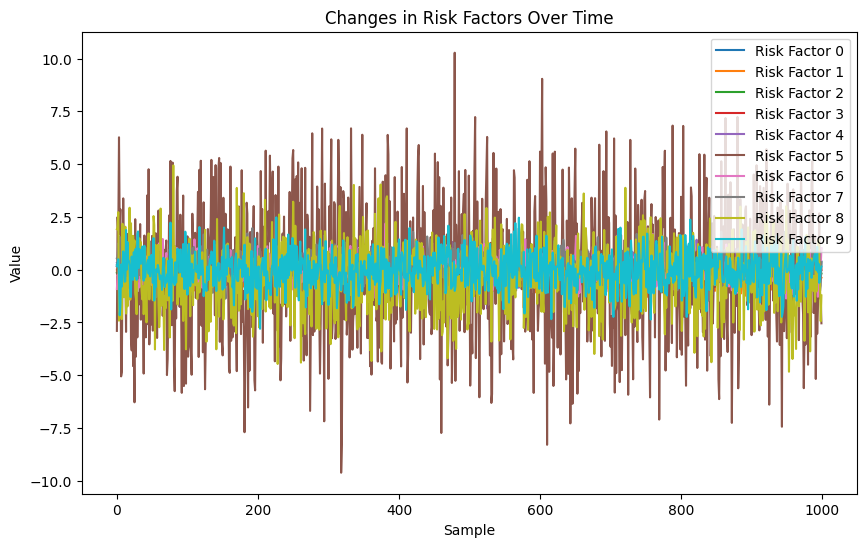

In [11]:
# Визуализация изменений в стоимости портфеля за каждый день симуляции
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(np.arange(num_samples), dict_of_risk_simulations[f'risk_factor_{i}'][:, -1], label=f'Risk Factor {i}')
plt.title('Changes in Risk Factors Over Time')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()

### Результаты пункта 5 ###
* Построена выборка из распределения риск-факторов на горизонте оценки риска - это реализовано в функции `calc_and_simulate_risk_factors`.
* По выборке значений риск-факторов построена выборка стоимостей портфеля - это реализовано в функции `calculate_portfolio_values`.
* Ребалансировка активов, чтобы сохранить пропорции, указанные в условии, осуществляется ежедневно через расчет новых цен на основе симуляций.

# Пункт 6

In [21]:
from scipy.stats import binom_test
from tqdm import tqdm

In [22]:
# Отбираем торговые дни 2023
backtest_dt = dataset.dt[dataset.dt.dt.year == 2023].to_frame()
# Каждому торговому дню ставим в пару предыдущий (нужен для взятия стартовых цен)
backtest_dt['lag'] = backtest_dt.shift()
# Заполняем пропущенный лаг для первого торгового дня в 2023
backtest_dt.lag = backtest_dt.lag.fillna(dataset.dt[dataset.dt.dt.year == 2022].max())
# Каждому торговому дню ставим в пару Т+10 день (нужен для взятия фактических цен на горизонте 10 дней)
# Здесь берем 9, потому что функция calculate_portfolio_value не учитывает сам день, а берет все дни до него
backtest_dt['lead_10'] = dataset.dt.shift(-9)
# Дропаем даты, для которых не доступны данные для сверки
backtest_dt = backtest_dt.dropna()

# Фичи
financial_columns = [
    'close_B_1', 'close_B_2', 'close_B_3', 'close_B_4', 'close_B_5',
    'close_AFKS', 'close_AGRO', 'close_BRENT', 'close_EUR_RUB__TOD',
    'close_GAZP', 'close_IMOEX', 'close_LKOH', 'close_NLMK', 'close_NVTK',
    'close_PLZL', 'close_ROSN', 'close_RTKM', 'close_RTSI', 'close_SBER',
    'close_USD000000TOD', '%_0,25y', '%_0,5y', '%_0,75y', '%_1y', '%_2y',
    '%_3y', '%_5y', '%_7y', '%_10y', '%_15y', '%_20y', '%_30y'
]
# Cостав портфелей
portfolios = dict(
    portfolio=[
        'close_AFKS', 'close_AGRO', 'close_GAZP', 'close_LKOH', 'close_NLMK',
        'close_NVTK', 'close_PLZL', 'close_ROSN', 'close_RTKM', 'close_SBER',
        'close_B_1', 'close_B_2', 'close_B_3', 'close_B_4', 'close_B_5',
        'close_EUR_RUB__TOD', 'close_USD000000TOD'
    ],
    shares=[
        'close_AFKS', 'close_AGRO', 'close_GAZP', 'close_LKOH', 'close_NLMK',
        'close_NVTK', 'close_PLZL', 'close_ROSN', 'close_RTKM', 'close_SBER'
    ],
    bonds=['close_B_1', 'close_B_2', 'close_B_3', 'close_B_4', 'close_B_5'],
    currencies=['close_EUR_RUB__TOD', 'close_USD000000TOD']
)
# Форма для записи результатов симуляций
backtest_results = {
    key: pd.DataFrame(
        data=np.zeros((2, 2)),
        index=[1, 10],
        columns=['success', 'trials']
    ) for key in portfolios.keys()
}



# Проводим расчет п.5
# На каждый торговый день 2023
for i in tqdm(backtest_dt.index):

    # Для всего портфеля и подпортфелей
    for p in portfolios.keys():

        # Определяем начальные условия
        dt_end = backtest_dt.loc[i, 'dt']
        steps_forward_1 = 1
        steps_forward_10 = 10
        num_samples = 1000
        initial_prices = dataset[dataset['dt'] == backtest_dt.loc[i, 'lag']].iloc[0][financial_columns].to_dict() # !!!
        # Равные веса
        portfolio_weights = {col: 1/len(financial_columns) for col in financial_columns} # !!!

        # Определяем фактическую стоимость портфеля
        portfolio_prices_1 = dataset[dataset.dt == dt_end][portfolios[p]].iloc[0]
        portfolio_prices_10 = dataset[dataset.dt == backtest_dt.loc[i, 'lead_10']][portfolios[p]].iloc[0]
        portfolio_value_1 = (portfolio_prices_1 * pd.Series({col: 1/len(portfolios[p]) for col in portfolios[p]})).sum() # !!!
        portfolio_value_10 = (portfolio_prices_10 * pd.Series({col: 1/len(portfolios[p]) for col in portfolios[p]})).sum() # !!!


        # Симуляции и расчет для горизонта 1 день
        df_risks, risk_simulations = calc_and_simulate_risk_factors(
            dt_end=dt_end,
            steps_forward=steps_forward_1,
            num_samples=num_samples,
            dataset=dataset,
            financial_columns=financial_columns
        )
        portfolio_values_1 = calculate_portfolio_values(
            df_risks,
            risk_simulations,
            initial_prices,
            portfolio_weights
        )
        var_1, _ = calculate_var_es(portfolio_values_1)

        # Симуляции и расчет для горизонта 10 дней
        df_risks, risk_simulations = calc_and_simulate_risk_factors(
            dt_end=dt_end,
            steps_forward=steps_forward_10,
            num_samples=num_samples,
            dataset=dataset,
            financial_columns=financial_columns
        )
        portfolio_values_10 = calculate_portfolio_values(
            df_risks,
            risk_simulations,
            initial_prices,
            portfolio_weights
        )
        var_10, _ = calculate_var_es(portfolio_values_10)

        # Записываем результат симуляции
        backtest_results[p].loc[:, 'trials'] += 1
        backtest_results[p].loc[1, 'success'] += int(portfolio_value_1 >= var_1)
        backtest_results[p].loc[10, 'success'] += int(portfolio_value_10 >= var_10)

print('Завершено успешно!')

 20%|██        | 45/225 [24:57<1:39:50, 33.28s/it]


KeyboardInterrupt: 

In [23]:
backtest_results

{'portfolio':     success  trials
 1      46.0    46.0
 10     46.0    46.0,
 'shares':     success  trials
 1      45.0    45.0
 10     45.0    45.0,
 'bonds':     success  trials
 1      45.0    45.0
 10     45.0    45.0,
 'currencies':     success  trials
 1      45.0    45.0
 10     45.0    45.0}

In [24]:
# Проверяем гипотезу о корректности оценки - проводим двухсторонний тест Бернулли
# (По сути мы последовательно проводим независимые испытания с бинарным исходом (норма/пробитие) с известной вероятностью успеха 0.99)
# (Ошибаться нам невыгодно в обе стороны, поэтому тест двухсторонний)
alternative = 'two-sided'
significance_level = 0.05



# Для каждого портфеля
for p in backtest_results.keys():

    # Для каждого горизонта
    for i in backtest_results[p].index:

        # Проводим тест
        pv = binom_test(
            backtest_results[p].loc[i, 'success'],
            backtest_results[p].loc[i, 'trials'],
            p=0.99,
            alternative=alternative
        )
        # Сохраняем p-value и вывод
        backtest_results[p].loc[i, 'p-value'] = pv
        backtest_results[p].loc[i, 'eval_correct'] = pv > significance_level

pd.concat(backtest_results)

success  trials  p-value eval_correct
portfolio  1      46.0    46.0      1.0         True
           10     46.0    46.0      1.0         True
shares     1      45.0    45.0      1.0         True
           10     45.0    45.0      1.0         True
bonds      1      45.0    45.0      1.0         True
           10     45.0    45.0      1.0         True
currencies 1      45.0    45.0      1.0         True
           10     45.0    45.0      1.0         True